# Nucleotide level interpretation of model at DNase HS sites

1. Comparison to SHARPR
2. Overlap with SiPhy conserved regions
3. Overlap with CENTIPEDE motifs
4. Average activities at motif instances, comparing cell types.

In [23]:
import numpy as np
from glob import glob
import gzip
from sklearn.metrics import r2_score
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

In [21]:
def quantile_plot(data_pairs, quantiles = 5000):
    data_pairs = sorted(data_pairs, key = lambda x: x[0])
    avg_activity, avg_score = [], []
    for i in range(0, len(data_pairs), len(data_pairs) / quantiles):
        index = range(i, min(i + (len(data_pairs) / quantiles), len(data_pairs)))
        activities = [data_pairs[j][0] for j in index]
        scores  = [data_pairs[j][1] for j in index]
        avg_activity.append(sum(activities) / float(len(activities)))
        avg_score.append(sum(scores) / float(len(scores)))
    i = 0
    while avg_activity[i] < 0: i += 1
    rho, pval = spearmanr(avg_activity[i:], avg_score[i:])
    print rho, pval
    plt.scatter(avg_activity, avg_score)
    plt.show()

# Load in importance scores

In [25]:
deep = {} # chrom -> position -> score
files = glob('../../data/dnase/hepg2_deeplift*')
for fn in files[:1]:
    with gzip.open(fn) as fp:
        for line in fp:
            chrom, pos, score = line.strip().split()
            if chrom not in deep:
                deep[chrom] = {}
            deep[chrom][int(pos)] = float(score)

# Comparison to SHARPR

# SiPhy Conservation

In [26]:
# Load in the data.
si_phi = {} # chrom, position, LOR (no entry implies not signiticant)
with gzip.open('../../data/conservation/hg19_29way_pi_lods_elements_12mers.chr_specific.fdr_0.1_with_scores.txt.gz') as conservation:
    for line in conservation:
        chrom, start, end, lor, branch = line.strip().split()
        start, end, lor = int(start), int(end), float(lor)
        if chrom not in deep: continue
        if chrom not in si_phi: si_phi[chrom] = {}
        if (start not in deep[chrom]
            and end not in deep[chrom]): continue
        for pos in range(start, end):
            si_phi[chrom][pos] = 1

In [36]:
deep_conserve = []
for chrom, positions in deep.items():
    for pos, score in positions.items():
        if chrom == 'chrY': continue
        deep_conserve.append((score, si_phi[chrom][pos] if pos in si_phi[chrom] else 0))

0.703668853092 1.62602755533e-185


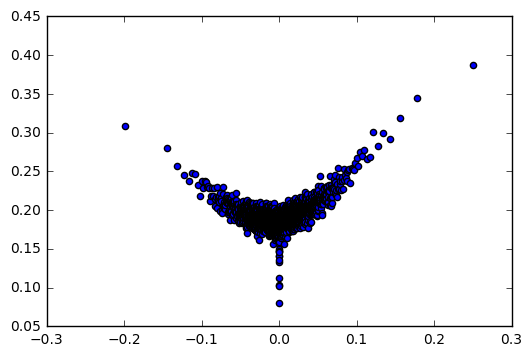

In [38]:
quantile_plot(deep_conserve, 2500)

# Comparison to CENTIPEDE motifs

In [30]:
hepG2_centipede = {}
with gzip.open('../../data/centipede/HEPG2_liftover.bed.gz') as regions:
    regions.readline()
    for line in regions:
        chrom, start, end, motif = line.strip().split()[:4]
        start, end = int(start), int(end)
        if chrom not in hepG2_centipede: hepG2_centipede[chrom] = {}
        for pos in range(start, end):
            hepG2_centipede[chrom][pos] = motif

In [33]:
deep_centipede = []
for chrom, positions in deep.items():
    for pos, score in positions.items():
        motif = 1 if pos in hepG2_centipede[chrom] else 0
        deep_centipede.append((score, motif))

0.774619540297 0.0


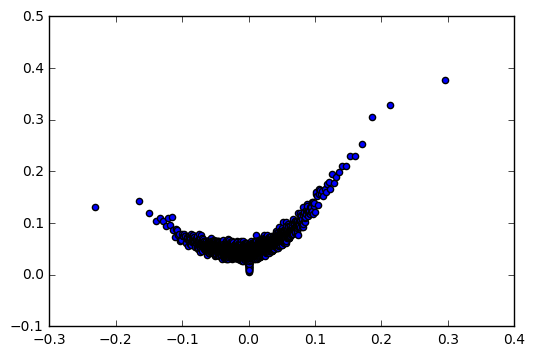

In [39]:
quantile_plot(deep_centipede, 5000)

# Differential motif analysis

Will need to rerun deeplift on k562 promoter! Probably should use minP....

In [ ]:
print deep_motif_scores.keys()
hepG2, k562 = [], []
exp1, exp2 = ('SV40P', 'HepG2'), ('SV40P', 'K562')
print len(deep_motif_scores[exp1].keys())
for motif, h in deep_motif_scores[exp1].items():
    if not motif in deep_motif_scores[exp2]: continue
    k = deep_motif_scores[exp2][motif]
    
    hepG2 += [sum(h) / float(len(h))]
    k562 += [sum(k) / float(len(k))]
plt.scatter(hepG2, k562)
plt.show()

In [ ]:
encode = {}
with open('../data/encode/matches.txt') as regions:
    for i, line in enumerate(regions):
        motif, chrom, start, end, strand = line.strip().split()
        start, end = int(start), int(end)
        if chrom not in encode: encode[chrom] = {}
        if start not in sharpr.values()[0][chrom]: continue
        for pos in range(start, end):
            if pos not in encode[chrom]: encode[chrom][pos] = set()
            encode[chrom][pos].add(motif)